<a href="https://colab.research.google.com/github/aashrithresearch/endometrial-adenocarcinoma/blob/main/models/efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import torch
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/histopathological image dataset for ET'

In [ ]:
print(os.listdir(path))

['EA', 'Non EA', 'feature_dict.p', 'lsh.p']


In [ ]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed=42, valid_pct=0.2),
                   item_tfms = Resize(128),
                   batch_tfms = aug_transforms(mult=2))
dls = dblock.dataloaders(path, dl_type=WeightedDL, bs=32)

In [ ]:
train_ds = dls.train_ds

from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Non EA: 2222
EA: 422


In [ ]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])

print("Number of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the validation set:
Non EA: 548
EA: 113


In [ ]:
metrics = [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro'),
]
learn = vision_learner(dls, efficientnet_v2_l, metrics=metrics, cbs=[GradientAccumulation(n_acc=16)], loss_func=FocalLoss(), opt_func=Adam).to_fp16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:34<00:00, 13.9MB/s]


SuggestedLRs(valley=0.004365158267319202)

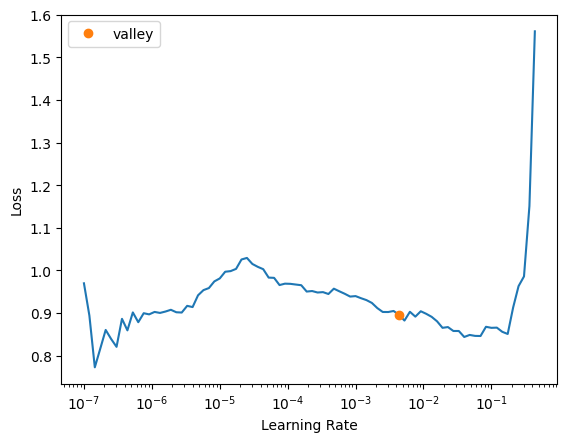

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.852955,0.439090,0.526475,0.588585,0.651193,0.497780,06:21
1,0.608094,0.280991,0.698941,0.652217,0.762233,0.639715,01:29
2,0.441168,0.139436,0.854766,0.744383,0.757864,0.750754,00:54
3,0.320158,0.107327,0.883510,0.815168,0.736564,0.766417,00:48
4,0.215401,0.117594,0.874433,0.809015,0.695966,0.731848,00:44
5,0.169492,0.076931,0.886536,0.809618,0.766488,0.785208,00:43
6,0.146227,0.078795,0.880484,0.785762,0.836598,0.806923,00:45
7,0.111604,0.079829,0.881997,0.788105,0.833998,0.807619,00:45
8,0.098440,0.070821,0.903177,0.827127,0.836235,0.831566,00:45
9,0.095733,0.067210,0.895613,0.831942,0.775475,0.799218,00:43


In [ ]:
learn.save('efficientnet stage1')

Path('models/efficientnet stage1.pth')

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

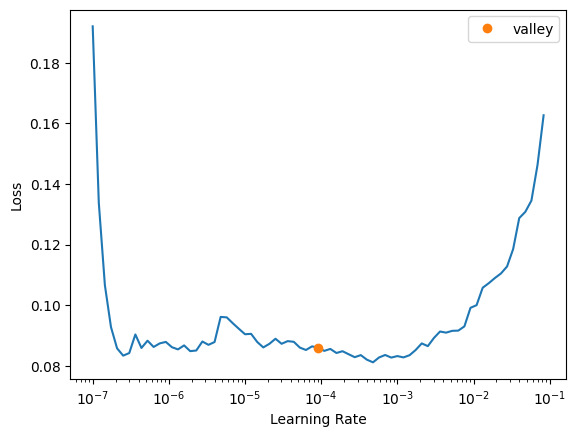

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 1e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.093971,0.066828,0.892587,0.851777,0.735014,0.774843,00:45
1,0.086946,0.065377,0.898638,0.850721,0.763250,0.796753,00:45
2,0.082119,0.063079,0.903177,0.859855,0.773012,0.806683,00:46
3,0.080844,0.061823,0.904690,0.868232,0.770412,0.807227,00:46
4,0.079773,0.057862,0.903177,0.851606,0.783549,0.811480,00:46
5,0.081702,0.056100,0.918306,0.887939,0.806723,0.839615,00:46
6,0.079421,0.058008,0.915280,0.864992,0.822460,0.841487,00:46
7,0.075466,0.057281,0.904690,0.851236,0.791486,0.816677,00:45
8,0.075419,0.056656,0.906203,0.848875,0.802936,0.823134,00:45
9,0.074573,0.054828,0.909228,0.849045,0.818810,0.832737,00:45


In [ ]:
learn.save('efficientnet stage2')

Path('models/efficientnet stage2.pth')

SuggestedLRs(valley=3.0199516913853586e-05)

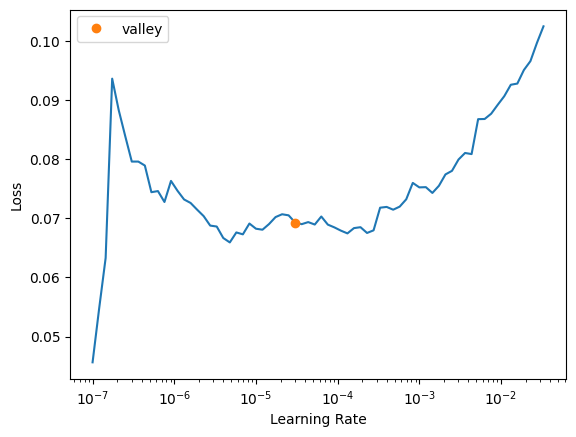

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 1e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.070286,0.055814,0.904690,0.846824,0.798511,0.819575,00:47
1,0.078946,0.052121,0.919818,0.889636,0.811148,0.843237,00:46
2,0.072160,0.053715,0.912254,0.858951,0.817123,0.835826,00:47
3,0.069771,0.053824,0.916793,0.866876,0.826885,0.844916,00:46
4,0.069995,0.053894,0.916793,0.866876,0.826885,0.844916,00:46
5,0.070681,0.050543,0.925870,0.884846,0.842896,0.861834,00:47
6,0.065028,0.052408,0.921331,0.874681,0.836647,0.853935,00:46
7,0.067015,0.053072,0.921331,0.858283,0.868258,0.863147,00:46
8,0.066844,0.051807,0.918306,0.887939,0.806723,0.839615,00:46
9,0.063883,0.050635,0.928896,0.879270,0.865795,0.872321,00:46


In [ ]:
learn.export('efficientnet.pkl')

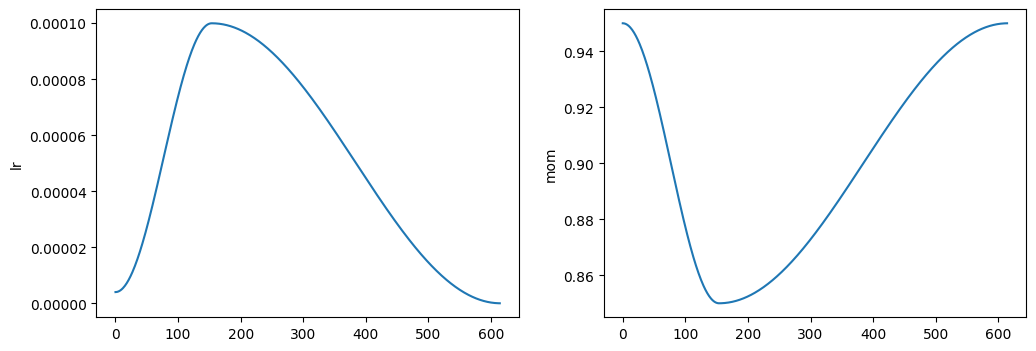

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn = learn.load('densenet121 stage2')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

AssertionError: ==:
1320
660